In [51]:
import pkg_resources
from darkmode import darkmode_orange # pylint: disable=unused-import
try:
    pkg_resources.require(['eth-ape','ape-alchemy','ape-etherscan','mplfinance', 'pandas', 'numpy', 'python-dotenv'])
    print('All packages installed')
except:
    !pip3 install eth-ape ape-alchemy ape-etherscan mplfinance pandas numpy python-dotenv

All packages installed


In [52]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import typing as tp
import os
from ape import accounts, chain, Contract, networks

In [53]:
# manually input your keys like this
# %env WEB3_ALCHEMY_API_KEY = xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# %env ETHERSCAN_API = xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# or load from a separate ".env" file, which is more secure!
from dotenv import load_dotenv
load_dotenv()

True

In [54]:
context = networks.parse_network_choice(f"ethereum:mainnet:https://mainnet.infura.io/v3/{os.getenv('INFURA_API_KEY')}")
context.__enter__()
print(f"ape version: {pkg_resources.get_distribution('eth-ape').version}")
print(f"provider.config of type={type(context.provider.config)}")
for k,v in context.provider.config.Config.__dict__.items():
    if not k.startswith('__'):
        print(f" {k} = {v}")


INFO: Connecting to existing Geth node at  https://mainnet.infura.io/v3/0adcd5893aa345109328472d2ddd0426.
ape version: 0.6.8
provider.config of type=<class 'ape_geth.provider.GethConfig'>
 extra = allow


In [55]:
# list plugins and available networks
for plugin_name, ecosystem_class in context.plugin_manager.providers:
    print(f"plugin_name={plugin_name}, ecosystem_class={ecosystem_class}")

plugin_name=alchemy, ecosystem_class=('ethereum', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('ethereum', 'goerli', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('ethereum', 'sepolia', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('arbitrum', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('arbitrum', 'goerli', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('optimism', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('optimism', 'goerli', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('polygon', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('polygon', 'mumbai', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=test, ecosystem_class=('ethereum', 'local', <class 'ape_test.provider.LocalProvider'>

In [56]:
# get an account that you can use
dev = accounts.test_accounts[0]
print(f"{dev.balance=}")

dev.balance=0


In [57]:
current_block = chain.blocks[-1].number
print(f"{current_block=}")

current_block=17192524


In [58]:
# determine starting block for the query
seconds_in_day = 86400
seconds_in_block = 12
last_number_of_days = 365
dblocks = int(seconds_in_day*last_number_of_days/seconds_in_block)
start_block = current_block - dblocks
print(f"starting block is {start_block:,.0f} for {last_number_of_days} day lookback")

starting block is 14,564,524 for 365 day lookback


In [59]:
# set up contracts, ABIs come from Etherscan
curve_steth = Contract("0xDC24316b9AE028F1497c275EB9192a3Ea0f67022")
steth = Contract("0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84")
print(f"balance of curve_steth is {steth.balanceOf(curve_steth)/1e18:,.0f} stETH")

balance of curve_steth is 346,230 stETH


In [60]:
# identify the event we want to query
display(curve_steth.TokenExchange)
display(type(curve_steth.TokenExchange))

TokenExchange(address indexed buyer, int128 sold_id, uint256 tokens_sold, int128 bought_id, uint256 tokens_bought)

ape.contracts.base.ContractEvent

In [61]:
# query it
%time query_swaps_recent = curve_steth.TokenExchange.query("*", start_block=current_block-3000) # last 10 hr
query_swaps_recent.head(5) # it's a pandas dataframe 🙌

CPU times: user 37.9 ms, sys: 3.48 ms, total: 41.4 ms
Wall time: 201 ms


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x1199193579d9e9c6f1293998bf3a8d0a65ae9d201237...,17189594,0x3014ab7656a231ffedebdce7305fbc4b1645407f233a...,221,92
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x0000000000a84D1a9B0063A910315C7fF...,0x580bbebbc02181ad22db6a15d9a79e9e14af57b1712c...,17189597,0x001ccee0428ac670e7006943342de872e2d6ee6defd8...,23,3
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x1136B25047E142Fa3018184793aEc68fB...,0x1c7e2dbd76df5c7f1537d9d5377304e397be2b400c2b...,17189626,0xf22056cf429f214969a7d811a045aa31358aa29f1706...,245,76
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xd669621C0F97B11f8E74Fa57bBF7e33dF...,0x4f45bca0a92453500d8a476063dbf2db7d801ed44571...,17189783,0x266aac769698dad8ae37c89cb887969904d7ade40c1b...,213,75
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xb7b47a182c22581aa0376771310db7d3f6ce0d74afb7...,17189816,0x862907da53a084381c2604e7b018cb510e154f8db511...,108,16


In [62]:
# the event arguments field is a dict of the event arguments
display(query_swaps_recent["event_arguments"][0])

{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85C178C18',
 'sold_id': 0,
 'tokens_sold': 1066757696656800,
 'bought_id': 1,
 'tokens_bought': 1066758029431578}

In [63]:
# ok great. let's look a bit further into the past to start_block from above. see how long it takes
%time query_swaps_original = curve_steth.TokenExchange.query("*", start_block=start_block)
query_swaps_original.head(5)

CPU times: user 22.1 s, sys: 403 ms, total: 22.5 s
Wall time: 19.6 s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDf1B1abA9E86bd0c3b264B689D8Cd5C48...,0xe61861ceb9ce4c206429b8d0ce98fabe41797325ce33...,14564536,0xea7712f63c6a7faaa2b78a30c6f1a38592c097f5ff6f...,486,288
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x8e764bE4288B842791989DB5b8ec06727...,0xdab14f6d8f01f56e3c89cd5eeb25c144fba207ebe3b9...,14564686,0x6f365e20679769f1ede16e367b116c73a821da1c45cf...,143,55
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x7f53981e6ab18de95975bb65b4119c0a80ca2479663e...,14564717,0xf624d7d14de17201a5588fd4e67842e26d13df9841ec...,237,139
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0x666c9ce15b870eab687fbda36866211e1e418294be2a...,14564751,0xd05bcdd6fab11f4433853397b401bcba774e74de5384...,214,90
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x40011Fed885d26dDa406094f30dEA8f49...,0xcc78ead1f4187bb27022a5bca2fec7154f77d907ea3b...,14564765,0x618541384bf9ad30bb724baf979bbd0d12f16879caaf...,103,57


In [64]:
query_swaps = query_swaps_original.copy()
query_swaps["tokens_sold"] = query_swaps["event_arguments"].apply(lambda x: x["tokens_sold"])
query_swaps = query_swaps.loc[query_swaps['tokens_sold'] > 0,:]
print(f"query_swaps shrunk from {len(query_swaps_original)} to {len(query_swaps)} rows by removing {len(query_swaps_original)-len(query_swaps)} rows with tokens_sold=0")

query_swaps shrunk from 67942 to 67938 rows by removing 4 rows with tokens_sold=0


In [65]:
# get coin indices:
#  - 0 = ETH (native)
#  - 1 = stETH
coin_indices = [curve_steth.coins(i) for i in range(2)]
print(f"{coin_indices=}")

coin_indices=['0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE', '0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84']


In [66]:
steth.address == coin_indices[-1]

True

In [67]:
# cache the fee to calculate associated price correctly (prior to fees applied)
curve_steth_fee = curve_steth.fee() / 1e10  # fee denom is 1e10
print(f"{curve_steth_fee=}")

curve_steth_fee=0.0004


In [68]:
# if sold_id == 1, then selling stETH for ETH, which is price wanted
#  i.e. quote = <ETH>, base = <stETH>
last_swap = query_swaps["event_arguments"].iloc[-1]
print('last swap event:', last_swap)

last_price = last_swap['tokens_bought'] * (1+curve_steth_fee) / last_swap['tokens_sold']
if last_swap['sold_id'] == 0:
    last_price = 1 / last_price
print('price:', last_price)

last swap event: {'buyer': '0x99a58482BD75cbab83b27EC03CA68fF489b5788f', 'sold_id': 1, 'tokens_sold': 17000000000000000000, 'bought_id': 0, 'tokens_bought': 16984657814864192582}
price: 0.9994971575288316


In [69]:
# write a function that iterates over event_arguments to calculate marginal price from last token swap
def get_price(event_args: dict) -> float:
    price = event_args['tokens_bought'] * (1+curve_steth_fee) / event_args['tokens_sold']
    if event_args['sold_id'] == 0:
        price = 1 / price
    return price

In [70]:
# validate with logic in cell above for last price
get_price(query_swaps["event_arguments"].iloc[-1]) == last_price

True

In [71]:
# create new column with marginal price (stETH as base and ETH as quote, so should be at a discount)
%time query_swaps['price (STETH/ETH)'] = query_swaps['event_arguments'].apply(get_price)
query_swaps.head(5)

CPU times: user 54.4 ms, sys: 0 ns, total: 54.4 ms
Wall time: 53.7 ms


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH)
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDf1B1abA9E86bd0c3b264B689D8Cd5C48...,0xe61861ceb9ce4c206429b8d0ce98fabe41797325ce33...,14564536,0xea7712f63c6a7faaa2b78a30c6f1a38592c097f5ff6f...,486,288,10000000000000000000,0.998864
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x8e764bE4288B842791989DB5b8ec06727...,0xdab14f6d8f01f56e3c89cd5eeb25c144fba207ebe3b9...,14564686,0x6f365e20679769f1ede16e367b116c73a821da1c45cf...,143,55,4030795658071524182,0.998864
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x7f53981e6ab18de95975bb65b4119c0a80ca2479663e...,14564717,0xf624d7d14de17201a5588fd4e67842e26d13df9841ec...,237,139,29027981991561935158,0.998863
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0x666c9ce15b870eab687fbda36866211e1e418294be2a...,14564751,0xd05bcdd6fab11f4433853397b401bcba774e74de5384...,214,90,5579999000001067821,0.998862
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x40011Fed885d26dDa406094f30dEA8f49...,0xcc78ead1f4187bb27022a5bca2fec7154f77d907ea3b...,14564765,0x618541384bf9ad30bb724baf979bbd0d12f16879caaf...,103,57,5249564484417209000,0.998862


In [106]:
query_swaps.plot(x='block_number', y='price (STETH/ETH)')

TypeError: module() missing required argument 'name' (pos 1)

<Axes: xlabel='block_number'>

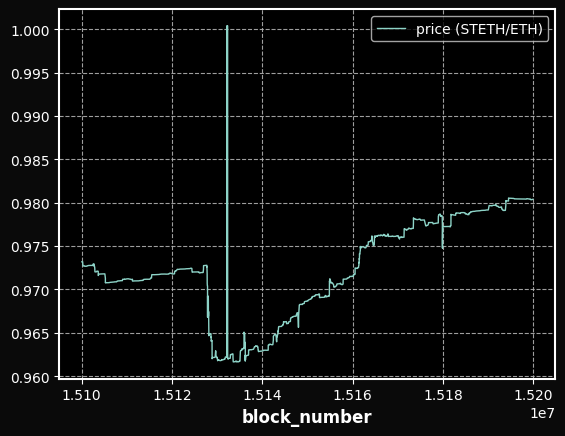

In [73]:
# well those are weird dips and spikes. look at smooth parts
query_swaps[(query_swaps['block_number'] > 15100000) & (query_swaps['block_number'] < 15200000)].plot(x='block_number', y='price (STETH/ETH)')

<Axes: xlabel='block_number'>

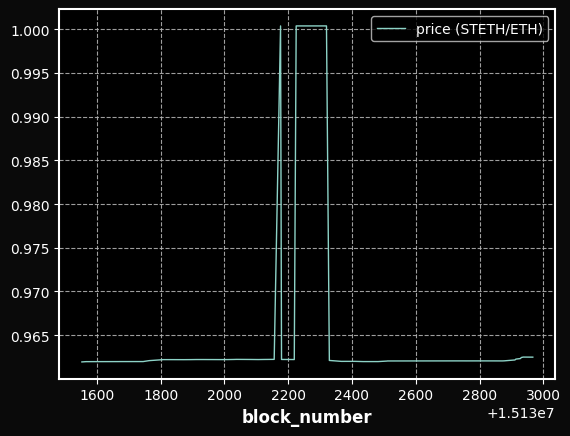

In [74]:
# weird spike for swaps back to 1.000 exchange rate. should look at this in event df
query_swaps[(query_swaps['block_number'] > 15131500) & (query_swaps['block_number'] < 15133000)].plot(x='block_number', y='price (STETH/ETH)')

In [75]:
# first, unfold event arguments into separate columns
def unfold_event_args(key: str, event_args: dict):
    return event_args[key]

for key in query_swaps.iloc[-1]['event_arguments'].keys():
    query_swaps[key] = query_swaps['event_arguments'].apply(lambda ev: unfold_event_args(key, ev))

In [76]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDf1B1abA9E86bd0c3b264B689D8Cd5C48...,0xe61861ceb9ce4c206429b8d0ce98fabe41797325ce33...,14564536,0xea7712f63c6a7faaa2b78a30c6f1a38592c097f5ff6f...,486,288,10000000000000000000,0.998864,0xDf1B1abA9E86bd0c3b264B689D8Cd5C4812f0cdd,1,0,9984648306739818054
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x8e764bE4288B842791989DB5b8ec06727...,0xdab14f6d8f01f56e3c89cd5eeb25c144fba207ebe3b9...,14564686,0x6f365e20679769f1ede16e367b116c73a821da1c45cf...,143,55,4030795658071524182,0.998864,0x8e764bE4288B842791989DB5b8ec067279829809,1,0,4024606663873612212
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x7f53981e6ab18de95975bb65b4119c0a80ca2479663e...,14564717,0xf624d7d14de17201a5588fd4e67842e26d13df9841ec...,237,139,29027981991561935158,0.998863,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,1,0,28983388107398573857
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0x666c9ce15b870eab687fbda36866211e1e418294be2a...,14564751,0xd05bcdd6fab11f4433853397b401bcba774e74de5384...,214,90,5579999000001067821,0.998862,0xDEF171Fe48CF0115B1d80b88dc8eAB59176FEe57,1,0,5571422061111647197
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x40011Fed885d26dDa406094f30dEA8f49...,0xcc78ead1f4187bb27022a5bca2fec7154f77d907ea3b...,14564765,0x618541384bf9ad30bb724baf979bbd0d12f16879caaf...,103,57,5249564484417209000,0.998862,0x40011Fed885d26dDa406094f30dEA8f49Aa4cAc6,1,0,5241494058285726651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67937,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x3185Fd8f4578f746441Eff27CEbCE8948...,0x065d070e7997f5b6384805d0ca3991628f14e4449f83...,17192383,0xa4c7ca73b5e58a642c3e65f3be37e74fe6a1aeac28df...,144,52,4312914589013558420,0.999494,0x3185Fd8f4578f746441Eff27CEbCE89480904C20,1,0,4309007710881342283
67938,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x99a58482BD75cbab83b27EC03CA68fF48...,0xf86ca22a2c62ff87debfcc3fbabdd469efe232c48634...,17192471,0x0cd15f1aa081ff166bb6f45003edf07db7a26410f6a4...,122,38,10000000000000000000,0.999495,0x99a58482BD75cbab83b27EC03CA68fF489b5788f,0,1,10001055771217278855
67939,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x0982bb975F4eEeA52ce98E41f5dBAb6b1...,0xe596f987648ba1b2db561865d061ee01dfe325f4933a...,17192471,0x0cd15f1aa081ff166bb6f45003edf07db7a26410f6a4...,200,78,373852331500000000,0.999495,0x0982bb975F4eEeA52ce98E41f5dBAb6b15eDf59D,1,0,373514212681202490
67940,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x99a58482BD75cbab83b27EC03CA68fF48...,0x3822fbf533b5d276cdbd9aced2daa6201f9f8ffa005a...,17192499,0xfe51dbc2d8595aac1f299ece2cc697070b55135dc076...,51,12,19000000000000000000,0.999497,0x99a58482BD75cbab83b27EC03CA68fF489b5788f,0,1,19001955528835282326


In [77]:
# now, check swaps where price spikes up to 1 between blocks 15132100 and 15132400
query_swaps[(query_swaps['block_number'] > 15132100) & (query_swaps['block_number'] < 15132400)]

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought
18350,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0xbaafb0dd80a49933313f5fae987331002fddd66ce398...,15132106,0x3f0dafa8c0bc1f75da4b77185df4b5e72f82367ce714...,6,1,9999999999999999,0.962210,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,9618254969587698
18351,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0x38ecea57eecc869cc4a62d96555f15ffe3136f32e06d...,15132124,0x97431fe5b1b89ff7dd6dd8c340ca44707052bbdf729f...,291,123,33697027127765331114,0.962220,0xfA9a30350048B2BF66865ee20363067c66f67e58,0,1,35006090866436268938
18352,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x0031130c56162e00A7e9C01eE4147b11c...,0xed21e5dc1f4099e247b0e815eb3874a7ff1d837d3a8e...,15132156,0x369ef5481d51a5d35c3e5fa176283314cdd284d829eb...,73,46,2461328000000000000,0.962230,0x0031130c56162e00A7e9C01eE4147b11cbac8776,0,1,2556919375120216623
18353,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x7438e5f555766a7f549d93c98022e0c6484729fa8d9f...,15132176,0x7905d8a7692da709cb1f9deaed58d35b3e29fa956fae...,34,10,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
18354,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0x722c4b153c4e33f1f5cbd0819d4847851d588d08184a...,15132179,0x8ec15d94c325e9e9552dc7f2c48e20f982ff5e694b3f...,40,24,35006090866436268938,0.962221,0xfA9a30350048B2BF66865ee20363067c66f67e58,1,0,33670122355004768780
18355,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x93Fa84f3102d45fC8e0721143c05b2c15...,0x510b3876226e4bc81ae5afeedc3754dffcd5842bbe1d...,15132219,0x57d3a5987fce344172cc3549db379419aff5745c1ccc...,323,144,1300000000000000000,0.962212,0x93Fa84f3102d45fC8e0721143c05b2c156026025,0,1,1350513053366563254
18356,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x56804547a6d74ac0152564a250aff84cea33b85ed53f...,15132225,0xc766211f83c2421824f805fd98f43bca867a03c63947...,62,8,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
18357,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x3356a73accd1729384e364750411036472c2b9ff5327...,15132229,0x368ab30333621f418f1f6634d737d72adb2f77421518...,58,12,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
18358,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0xd6978029b6bb52e8b4ffae55ce8f5a2de8b652ef0a1f...,15132280,0xd3893a3097aadadfa9fea3fadad6f7bdd48c54c03f80...,6,1,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
18359,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x93751a459ccb0838f4cfe07960e6afff4eeaf33facbe...,15132283,0x74c38343de39bd403e4c49b068e389068b21be043ef0...,6,1,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1


In [78]:
# ahh, ok :) .. someones selling 1 wei into the pool (see e.g. block 15132225)
# which is causing rounding issues for price calc

<Axes: xlabel='block_number'>

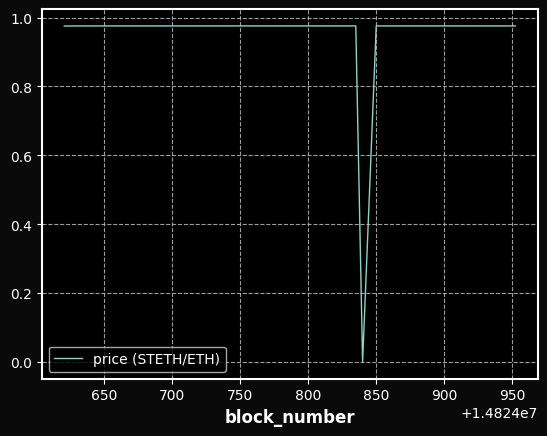

In [79]:
# are the dusting rounding issues also causing those spikes down to zero?
# look at first spike down to 0
query_swaps[(query_swaps['block_number'] > 14824600) & (query_swaps['block_number'] < 14825000)].plot(x='block_number', y='price (STETH/ETH)')

In [80]:
# looks like it (see swap at block 14824840); similar rounding issues except rounded down to zero here
query_swaps[(query_swaps['block_number'] > 14824600) & (query_swaps['block_number'] < 14825000)]

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought
7427,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x08CC4a936A24A278097FeB566Fccf71FF...,0xbefdc34be9f6d50dcf7d9692c834f2fcb750a7880a30...,14824621,0x10cf6cb3feb597dcaefdfa6fab3730491fea055a51b4...,236,204,2000000000000000000000,0.975627,0x08CC4a936A24A278097FeB566Fccf71FFe84A833,0,1,2049143953945768280377
7428,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x220bdA5c8994804Ac96ebe4DF184d25e5...,0xe7a98e6b9dbdab7e4e169efbb8ba055a9f0a28da8587...,14824663,0xc07d6c8038fd4165fd07386037f0a63b56701b00e1d7...,66,60,9669640333791112375,0.975835,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,0,1,9905129894611176792
7429,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x27239549DD40E1D60F5B80B0C41969237...,0xebbe2cac6a8cea633f4ce13aecc6b3d402f0a53de0df...,14824714,0x090d8bfa4b34ab2e8670c488fdde86fa8c5caef4cbd4...,115,81,4393970000000000000,0.975836,0x27239549DD40E1D60F5B80B0C4196923745B1FD2,1,0,4286080251138498473
7430,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x220bdA5c8994804Ac96ebe4DF184d25e5...,0x6a1a41032f086a90520761d6444937ff73b3aea580c2...,14824787,0x2749b488383fe28bb2abeab7d111d8472e406c445803...,150,92,1000730293446869257,0.975836,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,1,0,976157742840268152
7431,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xf97ecc3423d91b6f51e0f384518237b4c5439490f21f...,14824795,0x9038606c713de55bd5e65ed931117811e79820115ee7...,139,77,476594175496263493,0.975836,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,0,1,488200580530122222
7432,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x220bdA5c8994804Ac96ebe4DF184d25e5...,0xd3c3131024e6f4fb640f27a7a07513c44a4247ea663c...,14824820,0x0c7676c94dcc0bd3a33e55f1ae8bce51c723e1251f5d...,43,49,10000000000000000000,0.975835,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,1,0,9754443750619738380
7433,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xEda584Ac4234113e977Bd172e6393F579...,0x953204aa910f21a8012789670728e410039a8f9840b6...,14824835,0xfdf144489b7e75244e22839ce1c8a398f7745a57a1c0...,397,246,47870179539630044007,0.975829,0xEda584Ac4234113e977Bd172e6393F579282b816,1,0,46694419191845003347
7434,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xEda584Ac4234113e977Bd172e6393F579...,0xb2c64c3e9722df4fbcd79662cd6746e069ae08f55242...,14824840,0xfc556897c82ced07979693ce76cd27b4565e78cb0959...,462,195,1,0.000000,0xEda584Ac4234113e977Bd172e6393F579282b816,1,0,0
7435,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x27239549DD40E1D60F5B80B0C41969237...,0xc5de9e64196dff8dd176eece734d88b68e9f4e41cd1d...,14824850,0x1bc4068a1b8284a00ea135dc590d18744bf548a1c795...,84,43,1000000000000000000,0.975824,0x27239549DD40E1D60F5B80B0C4196923745B1FD2,0,1,1024364849804104284
7436,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x11CE580B7D64Fb08F73161AA95835202a...,0xe0c2a35ae160788e8d1d73a5bf465279363581af043f...,14824871,0x0f6bf5cc06980ac2ef46f0a73831494c426c0c9b3336...,394,188,381485996253488127,0.975824,0x11CE580B7D64Fb08F73161AA95835202ae1C9417,1,0,372114382696495947


In [81]:
# apply min size to swaps we care about to ignore the dustings
min_bought = 0.0001 * 1e18  # trade size must be > 0.0001 ETH 
query_swaps = query_swaps[query_swaps['tokens_bought'] > min_bought]

<Axes: xlabel='block_number'>

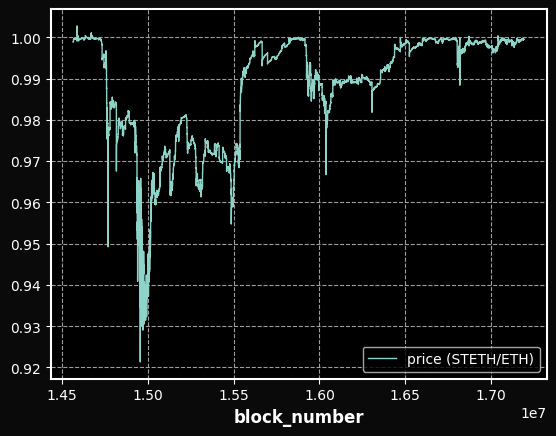

In [82]:
# nice! way better
query_swaps.plot(x='block_number', y='price (STETH/ETH)')

In [83]:
# should smooth the price data out so not so jittery by averaging over 1h for hourly candles.
# keep the volumes numbers as well, so make some slight changes to the (tokens_bought, tokens_sold)
# columns to instead track (volume_coin0, volume_coin1) at each swap

In [84]:
# write a function that returns volume on coin indices for a swap (normalized by 1e18 for decimals)
def get_volume(coin_index: int, x: pd.Series) -> (float, float):
    volume = x['tokens_sold'] if x['sold_id'] == coin_index else x['tokens_bought']
    volume = volume / 1e18
    return volume

In [85]:
%%capture
for coin_index in range(2):
    key = f'volume_coin{coin_index}'
    query_swaps[key] = query_swaps.apply(lambda x: get_volume(coin_index, x), axis=1)

In [86]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought,volume_coin0,volume_coin1
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDf1B1abA9E86bd0c3b264B689D8Cd5C48...,0xe61861ceb9ce4c206429b8d0ce98fabe41797325ce33...,14564536,0xea7712f63c6a7faaa2b78a30c6f1a38592c097f5ff6f...,486,288,10000000000000000000,0.998864,0xDf1B1abA9E86bd0c3b264B689D8Cd5C4812f0cdd,1,0,9984648306739818054,9.984648,10.000000
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x8e764bE4288B842791989DB5b8ec06727...,0xdab14f6d8f01f56e3c89cd5eeb25c144fba207ebe3b9...,14564686,0x6f365e20679769f1ede16e367b116c73a821da1c45cf...,143,55,4030795658071524182,0.998864,0x8e764bE4288B842791989DB5b8ec067279829809,1,0,4024606663873612212,4.024607,4.030796
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x7f53981e6ab18de95975bb65b4119c0a80ca2479663e...,14564717,0xf624d7d14de17201a5588fd4e67842e26d13df9841ec...,237,139,29027981991561935158,0.998863,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,1,0,28983388107398573857,28.983388,29.027982
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0x666c9ce15b870eab687fbda36866211e1e418294be2a...,14564751,0xd05bcdd6fab11f4433853397b401bcba774e74de5384...,214,90,5579999000001067821,0.998862,0xDEF171Fe48CF0115B1d80b88dc8eAB59176FEe57,1,0,5571422061111647197,5.571422,5.579999
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x40011Fed885d26dDa406094f30dEA8f49...,0xcc78ead1f4187bb27022a5bca2fec7154f77d907ea3b...,14564765,0x618541384bf9ad30bb724baf979bbd0d12f16879caaf...,103,57,5249564484417209000,0.998862,0x40011Fed885d26dDa406094f30dEA8f49Aa4cAc6,1,0,5241494058285726651,5.241494,5.249564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67937,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x3185Fd8f4578f746441Eff27CEbCE8948...,0x065d070e7997f5b6384805d0ca3991628f14e4449f83...,17192383,0xa4c7ca73b5e58a642c3e65f3be37e74fe6a1aeac28df...,144,52,4312914589013558420,0.999494,0x3185Fd8f4578f746441Eff27CEbCE89480904C20,1,0,4309007710881342283,4.309008,4.312915
67938,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x99a58482BD75cbab83b27EC03CA68fF48...,0xf86ca22a2c62ff87debfcc3fbabdd469efe232c48634...,17192471,0x0cd15f1aa081ff166bb6f45003edf07db7a26410f6a4...,122,38,10000000000000000000,0.999495,0x99a58482BD75cbab83b27EC03CA68fF489b5788f,0,1,10001055771217278855,10.000000,10.001056
67939,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x0982bb975F4eEeA52ce98E41f5dBAb6b1...,0xe596f987648ba1b2db561865d061ee01dfe325f4933a...,17192471,0x0cd15f1aa081ff166bb6f45003edf07db7a26410f6a4...,200,78,373852331500000000,0.999495,0x0982bb975F4eEeA52ce98E41f5dBAb6b15eDf59D,1,0,373514212681202490,0.373514,0.373852
67940,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x99a58482BD75cbab83b27EC03CA68fF48...,0x3822fbf533b5d276cdbd9aced2daa6201f9f8ffa005a...,17192499,0xfe51dbc2d8595aac1f299ece2cc697070b55135dc076...,51,12,19000000000000000000,0.999497,0x99a58482BD75cbab83b27EC03CA68fF489b5788f,0,1,19001955528835282326,19.000000,19.001956


In [87]:
# prep for smoothing by setting index to block number (choose last swap in block to represent price at block)
query_swaps_filtered = query_swaps.filter(['block_number', 'price (STETH/ETH)', 'volume_coin0', 'volume_coin1']).drop_duplicates('block_number', keep='last')
query_swaps_filtered = query_swaps_filtered.set_index('block_number')

In [88]:
# reindex by block number (1 block steps) and ffill price values 
new_index = range(query_swaps_filtered.index.min(), query_swaps_filtered.index.max()+1)
query_swaps_filtered = query_swaps_filtered.reindex(new_index).ffill()

In [89]:
# separate data into windows of 260 blocks (~ 1h)
# remove first (last_block - first_block) % window rows so even candle windows
window = 260
first_index = (query_swaps_filtered.index[-1] - query_swaps_filtered.index[0]) % window
query_swaps_filtered = query_swaps_filtered[first_index:]

In [90]:
# smooth data using mean over 260 blocks for ~ 1h candles
s = (query_swaps_filtered.index.to_series() / window).astype(int)
query_swaps_candled = query_swaps_filtered.groupby(s).agg({'price (STETH/ETH)': ['first', 'max', 'min', 'last', 'mean'], 'volume_coin0': 'sum', 'volume_coin1': 'sum'}).set_index(s.index[::window])
query_swaps_candled

price (STETH/ETH)                                          \
                         first       max       min      last      mean   
block_number                                                             
14564686              0.998864  0.998932  0.998862  0.998932  0.998869   
14564946              0.998932  0.998932  0.998928  0.998929  0.998930   
14565206              0.998929  0.998937  0.998922  0.998922  0.998931   
14565466              0.998922  0.998922  0.998917  0.998917  0.998918   
14565726              0.998917  0.999017  0.998917  0.999015  0.998995   
...                        ...       ...       ...       ...       ...   
17191466              0.999527  0.999527  0.999514  0.999514  0.999521   
17191726              0.999514  0.999514  0.999514  0.999514  0.999514   
17191986              0.999514  0.999514  0.999494  0.999495  0.999501   
17192246              0.999495  0.999497  0.999494  0.999497  0.999494   
17192506              0.999497  0.999497  0.999497  0.999497  0.999497   

               volume_coin0   volume_coin1  
                        sum            sum  
block_number                                
14564686       46992.268443   47027.021337  
14564946        4301.799461    4306.109799  
14565206       11231.449626   11240.503320  
14565466        3095.994754    3100.584796  
14565726      139831.906439  139924.738127  
...                     ...            ...  
17191466       14199.262423   14211.673507  
17191726         407.116935     407.477323  
17191986       10950.659521   10960.398701  
17192246         797.511410     798.192932  
17192506         130.984658     131.011733  

[10108 rows x 7 columns]

<Axes: xlabel='block_number'>

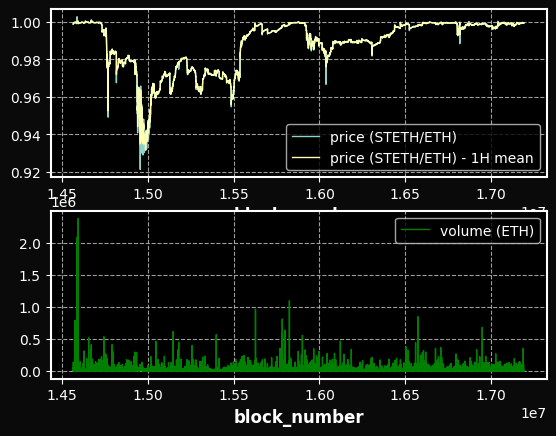

In [91]:
# make some fancy plots w subplots ...
fig, ax = plt.subplots(2, 1)
query_swaps.plot(x='block_number', y='price (STETH/ETH)', ax=ax[0])
query_swaps_candled['price (STETH/ETH)'].plot(y='mean', ax=ax[0], label='price (STETH/ETH) - 1H mean')
query_swaps_candled['volume_coin0'].plot(y='sum', color='g', ax=ax[1], label='volume (ETH)')

In [92]:
# plot the candles since that's dope :o

In [93]:
# get the timestamps every 24 candles (~ 24h) and interpolate the rest (SEE banteg gist again)
# NOTE: include last block in index for interp to work properly
T = 24
blocks = query_swaps_candled.index[::24].to_list() + [query_swaps_candled.index[-1]]

In [94]:
%time timestamps = [ chain.blocks[i].timestamp for i in blocks ]

CPU times: user 2.38 s, sys: 27.4 ms, total: 2.41 s
Wall time: 17.3 s


In [95]:
query_swaps_candled['timestamp'] = pd.to_datetime(np.interp(query_swaps_candled.index, blocks, timestamps) * 1e9)
query_swaps_candled

price (STETH/ETH)                                          \
                         first       max       min      last      mean   
block_number                                                             
14564686              0.998864  0.998932  0.998862  0.998932  0.998869   
14564946              0.998932  0.998932  0.998928  0.998929  0.998930   
14565206              0.998929  0.998937  0.998922  0.998922  0.998931   
14565466              0.998922  0.998922  0.998917  0.998917  0.998918   
14565726              0.998917  0.999017  0.998917  0.999015  0.998995   
...                        ...       ...       ...       ...       ...   
17191466              0.999527  0.999527  0.999514  0.999514  0.999521   
17191726              0.999514  0.999514  0.999514  0.999514  0.999514   
17191986              0.999514  0.999514  0.999494  0.999495  0.999501   
17192246              0.999495  0.999497  0.999494  0.999497  0.999494   
17192506              0.999497  0.999497  0.999497  0.999497  0.999497   

               volume_coin0   volume_coin1                     timestamp  
                        sum            sum                                
block_number                                                              
14564686       46992.268443   47027.021337 2022-04-11 13:35:31.000000000  
14564946        4301.799461    4306.109799 2022-04-11 14:34:55.624999936  
14565206       11231.449626   11240.503320 2022-04-11 15:34:20.249999872  
14565466        3095.994754    3100.584796 2022-04-11 16:33:44.875000064  
14565726      139831.906439  139924.738127 2022-04-11 17:33:09.500000000  
...                     ...            ...                           ...  
17191466       14199.262423   14211.673507 2023-05-05 02:28:38.000000000  
17191726         407.116935     407.477323 2023-05-05 03:21:11.000000000  
17191986       10950.659521   10960.398701 2023-05-05 04:13:55.000000000  
17192246         797.511410     798.192932 2023-05-05 05:06:39.000000000  
17192506         130.984658     131.011733 2023-05-05 05:59:23.000000000  

[10108 rows x 8 columns]

In [96]:
# put data into new df for ohlcv with 1h candles
query_swaps_ohlcv = pd.DataFrame({
    'Open': query_swaps_candled['price (STETH/ETH)']['first'],
    'High': query_swaps_candled['price (STETH/ETH)']['max'],
    'Low': query_swaps_candled['price (STETH/ETH)']['min'],
    'Close': query_swaps_candled['price (STETH/ETH)']['last'],
    'Volume': query_swaps_candled['volume_coin0']['sum'],
    'Date': query_swaps_candled['timestamp']
})
query_swaps_ohlcv = query_swaps_ohlcv.set_index('Date')
query_swaps_ohlcv

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-11 13:35:31.000000000,0.998864,0.998932,0.998862,0.998932,46992.268443
2022-04-11 14:34:55.624999936,0.998932,0.998932,0.998928,0.998929,4301.799461
2022-04-11 15:34:20.249999872,0.998929,0.998937,0.998922,0.998922,11231.449626
2022-04-11 16:33:44.875000064,0.998922,0.998922,0.998917,0.998917,3095.994754
2022-04-11 17:33:09.500000000,0.998917,0.999017,0.998917,0.999015,139831.906439
...,...,...,...,...,...
2023-05-05 02:28:38.000000000,0.999527,0.999527,0.999514,0.999514,14199.262423
2023-05-05 03:21:11.000000000,0.999514,0.999514,0.999514,0.999514,407.116935
2023-05-05 04:13:55.000000000,0.999514,0.999514,0.999494,0.999495,10950.659521


/home/mihai/.pyenv/versions/3.10.11/lib/python3.10/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


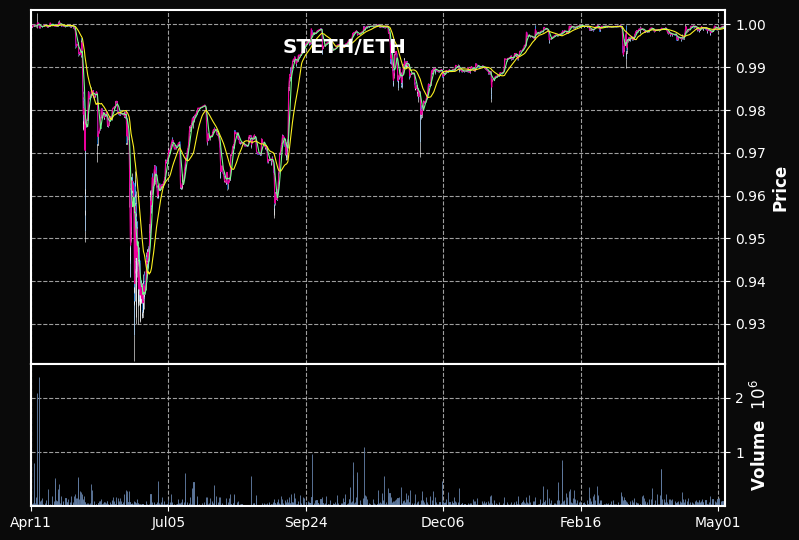

In [97]:
# oooooo fancy :)
def fancy_plot(
    data,
    mav=(10, 50),
    plt_type='candle',
    volume=True,
    datetime_format='%b%d',
    xrotation=0,
    tight_layout=True,
    style='mike', # mpf.available_styles() to pick your fav
    **kwargs
):
    mpf.plot(
        data,
        warn_too_much_data=2500,
        mav=mav,
        type=plt_type,
        volume=volume,
        datetime_format=datetime_format,
        xrotation=xrotation,
        tight_layout=tight_layout,
        style=style,
        **kwargs
    )

title="STETH/ETH"
fancy_plot(query_swaps_ohlcv, mav=(10, 50, 200), title=title)


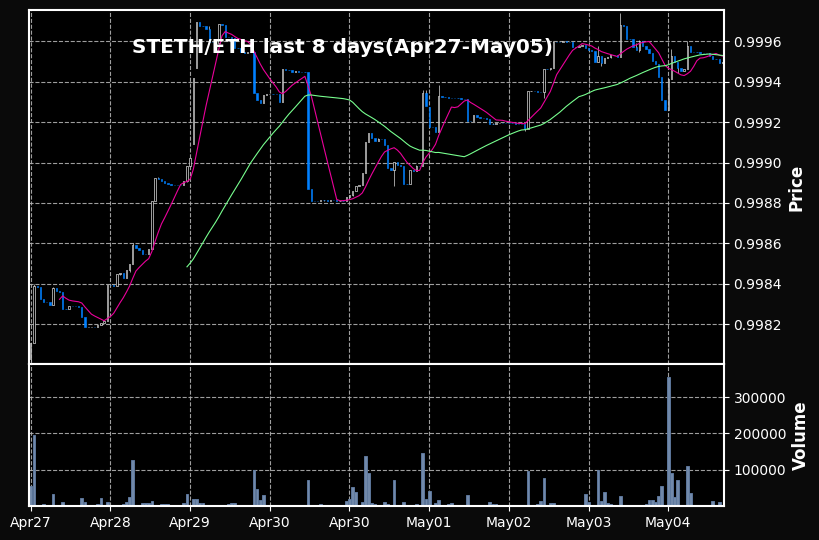

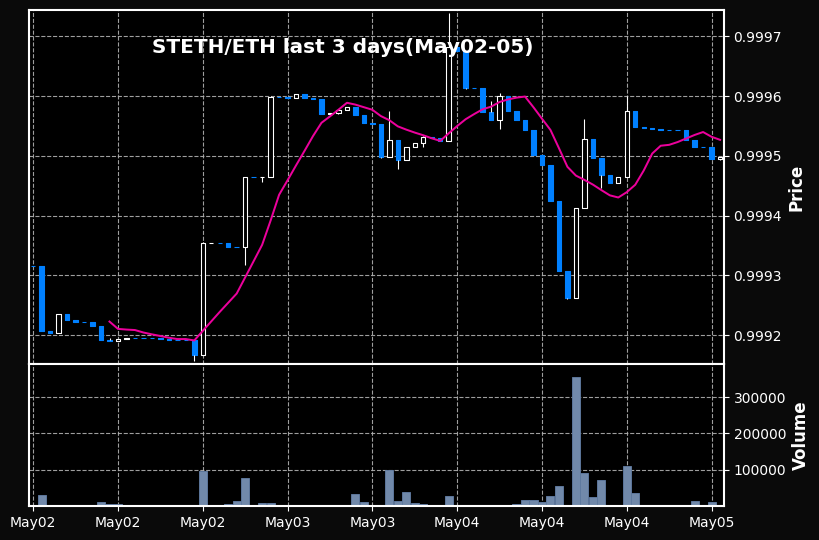

In [98]:
def plot_last_n_days(data, num_days_back=100, **kwargs):
    endPeriod = query_swaps_ohlcv.index[-1]
    startPeriod = endPeriod - pd.Timedelta(days=num_days_back)
    dataToPlot = data.loc[(data.index > startPeriod) & (data.index < endPeriod),:]
    title=f"STETH/ETH last {num_days_back} days"
    title+=f"({startPeriod:%b%d}-{endPeriod:%b%d})" if startPeriod.month != endPeriod.month else f"({startPeriod:%b%d}-{endPeriod:%d})"
    mav = [10]
    if num_days_back > 3:
        mav.append(50)
    if num_days_back > 10:
        mav.append(100)
    fancy_plot(dataToPlot, mav=mav, title=title)

plot_last_n_days(query_swaps_ohlcv, num_days_back=8)
plot_last_n_days(query_swaps_ohlcv, num_days_back=3)
